In [18]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addAtomIndices=True

from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField

from openmm import unit, app, LangevinIntegrator

# Demonstration of how to use SerenityFF as an OpenFF plugin for a Simulation

### Create the ForceField object

Since SerenityFF only changes the partial charges of the system we need a OpenFF file as a base. In this repository a modified version is included. The only modification is that the `Electrostatics` handler is set to `SerenityFF`. To load the Forcefield correctly `load_plugins=True` has to be set, and the SerenityFF package has to be installed properly, which should link the plugin to the ForceField object.

In [2]:
ff_path = "../data/openff-2.0.0-serenity.offxml"

In [3]:
ff = ForceField(ff_path, load_plugins=True)

### Create a openff molecule

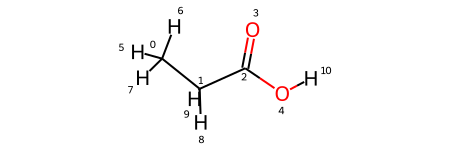

In [4]:
rdkit_mol = Chem.MolFromSmiles("CCC(=O)O")
rdkit_mol = Chem.AddHs(rdkit_mol)
AllChem.EmbedMolecule(rdkit_mol)
rdkit_mol

In [5]:
molecule = Molecule.from_rdkit(rdkit_mol)
topology = Topology.from_molecules(molecule)

In [6]:
partial_charges = ff.get_partial_charges(molecule=molecule)
partial_charges = partial_charges.value_in_unit(partial_charges.unit)
print(partial_charges)

[nan nan nan nan nan nan nan nan nan nan nan]


### Create a openmm system

In [7]:
openmm_system = ff.create_openmm_system(topology)

In [8]:
integrator = LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond, 4 * unit.femtosecond)

In [9]:
simulation = app.Simulation(topology.to_openmm(), openmm_system, integrator)

In [10]:
simulation.context.setPositions(molecule.conformers[0])

In [11]:
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)

In [12]:
simulation.reporters.append(app.StateDataReporter("./example_openmm.csv", 10, step=True, potentialEnergy=True, temperature=True))

### run a simulation

In [13]:
simulation.step(100)

ValueError: Energy is NaN

In [14]:
df_openmm = pd.read_csv("./example_openmm.csv")

In [15]:
df_openmm

,"#""Step""",Potential Energy (kJ/mole),Temperature (K)


In [16]:
df_openmm.plot(x="Step", y="Potential Energy (kJ/mole)")

KeyError: 'Step'

In [19]:
os.remove("./example_openmm.csv")